# Mahtab Nejati
# 98209434
# Problem 10

In [1]:
import pandas as pd
import numpy as np
from time import sleep
import murmurhash as mmh
import math
from statistics import median,mean
from random import uniform,shuffle
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from itertools import combinations

## Load in the NASA dataset
### Only kept the concatenation of host and url columns and their request arrival time.

In [2]:
df = pd.read_csv('./q10.csv')
remove_columns = list(df.columns)
remove_columns.remove('time')
df['address'] = df['host']+df['url']
df = df.drop(remove_columns,axis=1).set_index('time').sort_values(by='time')
unique_count = df.address.unique().shape[0]
n = len(df)
print('\nThe number of unique addresses in the dataset is:\n\t\t\t'+str(unique_count),end='\n\n')
print('Total length of stream is:\n\t\t\t'+str(n))


The number of unique addresses in the dataset is:
			1718139

Total length of stream is:
			2965561


## Part A: Flajolet Martin Algorithm

## Stream data

In [3]:
def stream_in_flajolet_martin(dataset,rate,l,max_len,tail_counts):
    tails =  tail_counts.copy()
    primes = get_primes(l,max_len)
    shuffle(primes)
    step = 0
    for time,address in  dataset.iterrows():
        step += 1
        tails = flajolet_martin(address['address'],l,primes,max_len,tails)
#         sleep(1/rate)
        if step == max_len:
            break
    return tails

## Generate prime numbers for hashing.

In [4]:
def get_primes(l,max_len):
    primes = []
    num = int(math.log2(max_len))
    while len(primes)<l:
        num+=1
        if all(num%i!=0 for i in range(2,num)):
            primes.append(num)
    return primes

## Hashing addresses

In [5]:
def hash_item(item,ith_hash,primes,max_len):
    p = primes[ith_hash]
    hashed = mmh.hash(item,p)
    return bin(hashed)[-int(math.log2(2*max_len)):]

## Counting zeros in the tail

In [6]:
def count_tail(hashed):
    if hashed[0] == 'b':
        hashed = hashed[1:]
    if int(hashed,2) == 0:
        return 0
    s = str(hashed)
    return len(s)-len(s.rstrip('0'))

## Flajolet Martin algorithm

In [7]:
def flajolet_martin(address,l,primes,max_len,tail_counts):
    tails = tail_counts.copy()
    for i in range(l):
        hashed = hash_item(address,i,primes,max_len)
        tail = count_tail(hashed)
        if tails[i] < tail:
            tails[i] = tail
    return tails

## Median of Averages
### Partitioning the list of tail_counts into "parts" partitions, getting the mean of each part and outputing the meadian of the averages.

In [8]:
def median_of_averages(l,parts,tail_counts):
    shuffle(tail_counts)
    avg = l / float(parts)
    results = []
    last = 0.0
    while last < len(tail_counts):
        results.append(mean(tail_counts[int(last):int(last + avg)]))
        last += avg

    estimated_uniques = 2**median(results)
    return estimated_uniques

## Flajolet Martin main

In [9]:
input_rate = 100000
max_stream_len = n

results_flajolet_martin = pd.DataFrame({'l':[],
                                        'parts':[],
                                        'estimation':[],
                                        'err':[]})

input_df = df.head(max_stream_len).copy()

for l in list(range(1,11)):
    tail_counts = [0]*l
    tail_counts = stream_in_flajolet_martin(input_df,input_rate,l,max_stream_len,tail_counts)
    for parts in list(range(1,l+1)):
        estimation = median_of_averages(l,parts,tail_counts)
        results_flajolet_martin = results_flajolet_martin.append({'l':l,
                                        'parts':parts,
                                        'estimation':estimation,
                                        'err':np.NaN},ignore_index=True)   


unique_count = input_df.address.unique().shape[0]
results_flajolet_martin['err'] = np.round((abs(results_flajolet_martin['estimation']-unique_count))*100/unique_count,2)

## Minimum error

In [10]:
minimum_err = results_flajolet_martin.loc[results_flajolet_martin['err']==min(results_flajolet_martin['err'])].copy()
minimum_err

,l,parts,estimation,err
41,9.0,6.0,1.482910e+06,13.69


## Plot the error with against number of hash functions (l) and number of partitions (parts)
### For detailed report, refer to the repost pdf file.

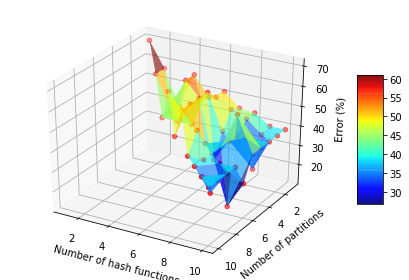

In [11]:
x = list(results_flajolet_martin['l'])
y = list(results_flajolet_martin['parts'])
z = list(results_flajolet_martin['err'])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x,y,z,color='red')


surf = ax.plot_trisurf(x,y,z,alpha=0.6,cmap=cm.jet)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.plot_trisurf
ax.invert_yaxis()

ax.set_xlabel('Number of hash functions')
ax.set_ylabel('Number of partitions')
ax.set_zlabel('Error (%)')
fig.tight_layout()
fig.savefig('q10_flajolet_martin_error')
plt.show()

## Part B: Alon–Matias–Szegedy Algorithm

## Stream data

In [12]:
def stream_in_alon_matias_szegedy(dataset,rate,l_counts,max_len,samples_counts):
    samples =  samples_counts.copy()
    ls = l_counts.copy()
    step = 0
    for time,address in  dataset.iterrows():
        step += 1
        ls,samples = alon_matias_szegedy(address['address'],ls,step,max_len,samples)
#         sleep(1/rate)
        if step == max_len:
            break
    return ls,samples

## Alon-Matias-Szegey algorithm

In [13]:
def alon_matias_szegedy(address,l_counts,step,max_len,samples_counts):
    samples = sample_counts.copy()
    ls = l_counts.copy()
    for i in range(len(ls)):
        if ls[i] < (i+1)*0.01*max_len:
            if uniform(0,1) < step/max_len:
                ls[i] += 1
                try:
                    x = samples[i][address]
                except KeyError:
                    samples[i][address]=0
        try:
            samples[i][address] += 1
        except KeyError:
            pass
    return ls,samples

## Alon-Matias-Szegedy main

In [14]:
input_rate = 100000
max_stream_len = n
max_l = 10

results_alon_matias_szegedy = pd.DataFrame({'l':[],
                                            'estimation':[]})

input_df = df.head(max_stream_len).copy()

for l in list(range(1,max_l+1)):
    l_counts = [0]*l
    sample_counts = []
    for i in range(l):
        sample_counts.append({}.copy())
    l_counts,smaple_counts = stream_in_alon_matias_szegedy(input_df,input_rate,l_counts,max_stream_len,sample_counts)
    all_second_moments = [sum([v**2 for k,v in sample_counts[i].items()]) for i in range(l)]
    estimated_second_moment = mean(all_second_moments)
    results_alon_matias_szegedy = results_alon_matias_szegedy.append({'l':l,
                                        'estimation':estimated_second_moment},ignore_index=True)

## Plot the 2-nd moment against number of hash functions (l)
### For detailed report, refer to the repost pdf file.

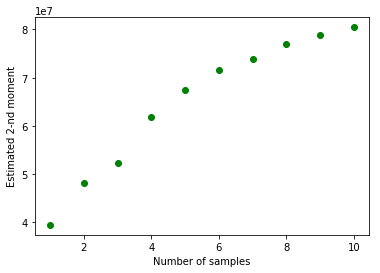

In [17]:
x = results_alon_matias_szegedy['l']
y = results_alon_matias_szegedy['estimation']

plt.scatter(x=x, y=y, color='green')
plt.xlabel("Number of samples")
plt.ylabel("Estimated 2-nd moment")
fig.tight_layout()
plt.savefig('q10_alon_matias_szegedy_estimations')
plt.show()